# Unified angular acceptance
This notebook is explaining the process and also generates the unified angular acceptance model

In [1]:
from __future__ import division, print_function
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
from scipy import stats
from scipy import optimize
from sklearn.decomposition import PCA
from scipy.integrate import quad
from matplotlib.pyplot import cm
from numpy.polynomial import polynomial
import hashlib
import os
import glob

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [4]:
def msu(coseta, p1=0.3, p2=0):
    '''
    MSU parameterization 
    https://wiki.icecube.wisc.edu/index.php/MSU_Forward_Hole_Ice
    '''
    f = lambda x : 0.34 * (1 + 1.5 * x - x**3/2.) + p1 * x * (x**2 -1)**3 +p2 * np.exp(10*(x-1.2))
    norm = quad(f, -1, 1)
    return f(coseta) * 0.68 / norm[0]

## Load some angular acceptance models
We load the input models for the parameterization, next cell selects the model we actually want

In [5]:
xnew = np.linspace(-1,1,101)

models = {}
files = [f for f in glob.glob('/cvmfs/icecube.opensciencegrid.org/py2-v3.0.1/metaprojects/simulation/V06-01-01/ice-models/resources/models/angsens/as.*')]
for file in files:
    #print(file)
    with open(file, 'r') as m:
        poly = m.readlines()
        poly = [float(c.strip()) for c in poly]
        f = polynomial.Polynomial(poly[1:])
        models[file.split('.')[-1]] = f(xnew)
        
# from Martin R.
f = polynomial.Polynomial([ 2.06777114e-14,  1.74719461e-14, -5.67238286e-14, -3.42800409e-14,  4.95514301e-14, -7.42966323e-02, -5.41036322e-03, -9.07768380e-02, -8.56063000e-02, 4.30334072e-01,  3.55900800e-01][::-1])
norm = quad(f, -1, 1)
models['martin_0.6_14'] = f(xnew) * 0.68 / norm[0]
f = polynomial.Polynomial([ 3.36087298e-14,  1.36499579e-14, -7.97723716e-14, -2.26422656e-14,  6.30906222e-14, -2.46424084e-01, -2.53383207e-01, -4.97533265e-02,  8.79281247e-02,  4.82721282e-01,  3.52484462e-01][::-1])
norm = quad(f, -1, 1)
models['martin_0.8_40'] = f(xnew) * 0.68 / norm[0]
f = polynomial.Polynomial([-2.32400791e-14,  1.17692970e-14,  4.23202843e-14, -2.87362984e-14, -2.51280360e-14, -5.00046160e-01, -6.38566738e-01,  7.87329961e-02,  3.45636471e-01,  4.76239349e-01,  3.51226068e-01][::-1])
norm = quad(f, -1, 1)
models['martin_1.8_125'] = f(xnew) * 0.68 / norm[0]

models['greco'] = msu(xnew, p1=(0.3+0.49*0.1), p2=-0.63)
models['dragon'] = msu(xnew, p1=(0.3-0.25*0.1), p2=-1.15)
models['baseline'] = msu(xnew, p1=(0.3), p2=-1)
models['msu2'] = msu(xnew, p1=(0.3), p2=1)
models['dima'] = msu(xnew, p1=(0.3), p2=0)
models['dima+'] = msu(xnew, p1=(0.4), p2=0)
models['dima-'] = msu(xnew, p1=(0.2), p2=0)

In [6]:
# only select the ones we are interested in
#models = {k: models[k] for k in ['h1-100cm', 'h2-50cm', 'h3-30cm', 'nominal', '30_p2_0', '25_p2_0', '35_p2_0', 'dragon', 'greco', 'baseline', '30_p2_+1']}
models = {k: models[k] for k in ['nominal', 'h1-100cm', 'h2-50cm', 'h3-30cm', 'dima', 'dima+', 'dima-', 'dragon', 'greco', 'baseline', 'msu2', 'martin_0.6_14', 'martin_0.8_40', 'martin_1.8_125']}
#models = {k: models[k] for k in ['nominal', 'dima', 'dima+', 'dima-', 'dragon', 'greco', 'baseline', 'msu2', 'martin_0.6_14', 'martin_0.8_40', 'martin_1.8_125']}

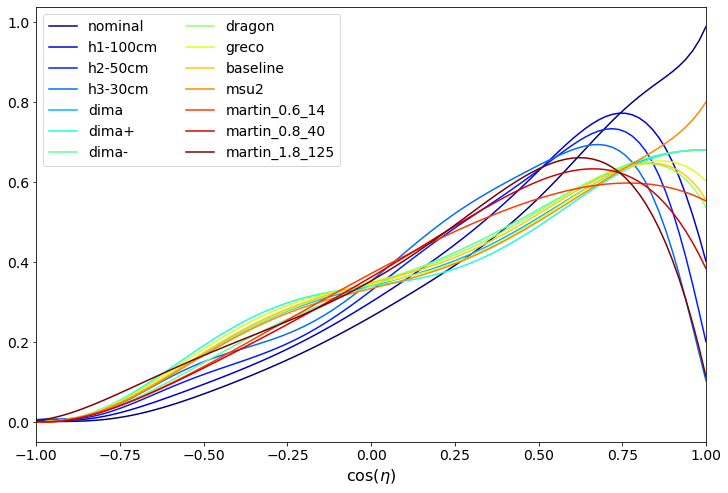

In [7]:
colors = cm.jet(np.linspace(0,1,len(models)))

for target, name, color in zip(models.values(), models.keys(), colors):
    plt.plot(xnew, target, label=name, c=color)

plt.gca().set_xlim([-1,1])
plt.gca().set_xlabel(r'$\cos(\eta)$')
plt.gca().legend(loc='upper left', ncol=2)
plt.savefig('all.png')

## Approximate those by splines
For doing that, we need to decide at which points we want to support the splines, this is `support_x`.
Then a minimizer is run to get the closest approximation of each model

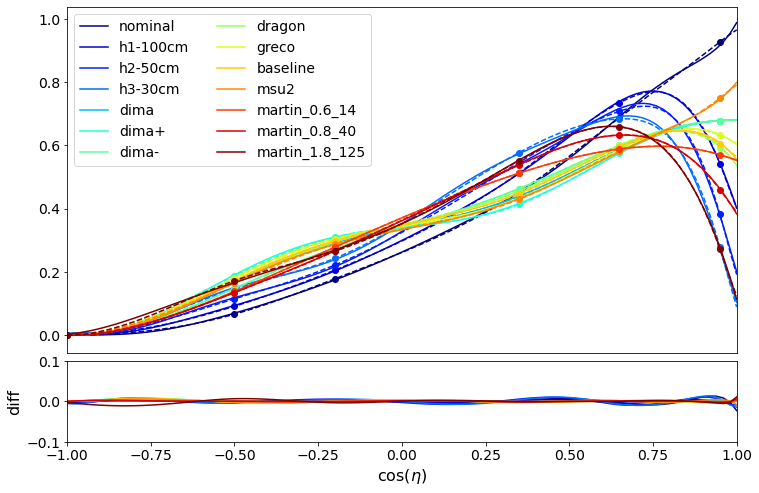

In [8]:
#support_x = np.array([-1., -0.5, -0.2, 0.2, 0.5, 0.75, 0.97, 1.])
support_x = np.array([-1., -0.5, -0.2, 0.35, 0.65, 0.95, 1.05])
#support_x = np.array([-1., -0.6,  0.2, 0.6, 0.75, 0.9, 1.])
#support_x = np.array([-1.  , -0.6 , -0.25,  0.1 ,  0.5 ,  0.9 ,  1.  ])

initial_y = np.ones_like(support_x) * 0.5

# this sets the derivative=0 boundary conditions
bc_type=([(1, 0.0)], [(1, 0.0)])
#bc_type=None

def fun(y, support_x, target):
    '''
    Minimizer objective
    '''
    # we fix the leftmost point to 0
    y[0] = 0
    cubic = make_interp_spline(support_x, y, bc_type=bc_type)
    diff = target - cubic(xnew)
    return np.sqrt(np.sum(np.square(diff)))

fig = plt.figure()
ax1 = plt.subplot2grid((10,1), (0,0), rowspan=8, fig=fig)
ax2 = plt.subplot2grid((10,1), (8,0),sharex=ax1,rowspan=2, fig=fig)

y_points = []

for target, name, color in zip(models.values(), models.keys(), colors):
    opt = optimize.minimize(fun, x0=initial_y, method='L-BFGS-B', args=(support_x, target))
    y = opt['x']
    y[0] = 0
    y_points.append(y)

    cubic = make_interp_spline(support_x, y, bc_type=bc_type)
    ax1.plot(support_x, y, 'o', c=color)
    ax1.plot(xnew, cubic(xnew), '--', c=color)
    ax1.plot(xnew, target, label=name, c=color)
    ax2.plot(xnew, cubic(xnew) - target, c=color)

y_points = np.stack(y_points)

ax1.set_xlim([-1,1])
ax2.set_xlim([-1,1])
ax1.get_xaxis().set_visible(False)

ax2.set_ylim([-0.1, 0.1])
ax2.hlines(0,-1,1)
ax2.set_ylabel('diff')
ax2.set_xlabel(r'$\cos(\eta)$')

ax1.legend(loc='best', ncol=2)
plt.show()
fig.savefig('approx.png')

# Reduce dimensionality
by doing a PCA decomposition and taking the two most important components

In [9]:
n_components=2

transformer = PCA(n_components=n_components, random_state=0)
out = transformer.fit_transform(y_points)

print(transformer.explained_variance_)
print(transformer.singular_values_)

[0.12035492 0.00565398]
[1.25084529 0.27111212]


-1.7446361815538174e-16 2.991303105787328
-2.1807952269422717e-17 13.801143807656258


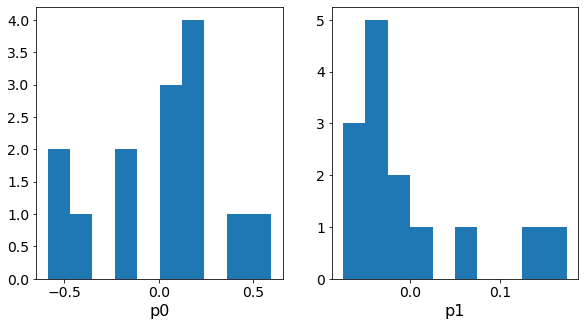

In [10]:
# let's investigate the interesting parameter ranges

fig = plt.figure(figsize=(15,5))
for i in range(out.shape[1]):
    ax = plt.subplot2grid((1,out.shape[1]+1), (0,i), rowspan=1, fig=fig)
    ax.hist(out[:,i])
    ax.set_xlabel('p%i'%i)
    print(np.mean(out[:,i]), 1./ np.std(out[:,i]))
plt.savefig('dist.png')

now we build a new function with 2 parameters

In [11]:
def ang(params, values):
    '''
    New angular acceptance funcion
    
    params : list / array
        the two parametrrs p1 and p2
    values : array
        the eta values to compute the angular acceptance for in (-1, 1)
    '''
    transformed_params = transformer.inverse_transform(params)
    f = make_interp_spline(support_x, transformed_params, bc_type=bc_type)
    positive_f = lambda x : np.clip(f(x), 0., None)
    
    norm = quad(positive_f, -1, 1)
    out = positive_f(values)
    #normalize....why 0.68?
    out /= norm[0] / 0.68
    
    return out

# Samples & Envelope
let's do some random sampling of the new function to see how it behaves

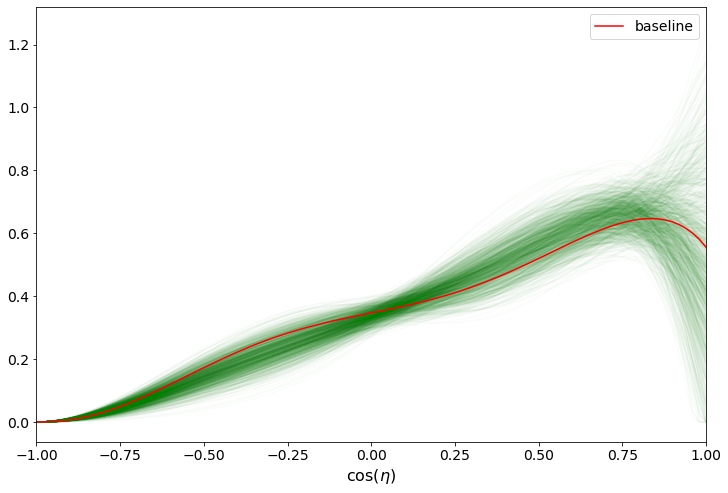

In [12]:
n = 1000

all_curves = np.ones(shape=(n, xnew.shape[0]))

for i in range(n):
    params = []
    for j in range(out.shape[1]):
        r = np.random.randn(1)
        params.append(r[0] * np.std(out[:,j]))
    all_curves[i] = ang(params, xnew)
    plt.plot(xnew, all_curves[i], c='green', alpha=20./n)
    #plt.plot(xnew, cubic(xnew), c='green', alpha=20./n)
                
plt.gca().set_xlim([-1,1])    
#plt.plot(xnew, msu(xnew, p1=0.2, p2=0), c='k')
plt.plot(xnew, models['baseline'], c='r', label='baseline')
#plt.plot(xnew, msu(xnew, p1=0.4, p2=0), c='k')
plt.legend()
plt.gca().set_xlabel(r'$\cos(\eta)$')
plt.savefig('rand.png')

In [13]:
p16 = np.percentile(all_curves, 16, axis=0)
p84 = np.percentile(all_curves, 86, axis=0)
p25 = np.percentile(all_curves, 2.5, axis=0)
p975 = np.percentile(all_curves, 97.5, axis=0)
p50 = np.percentile(all_curves, 50, axis=0)

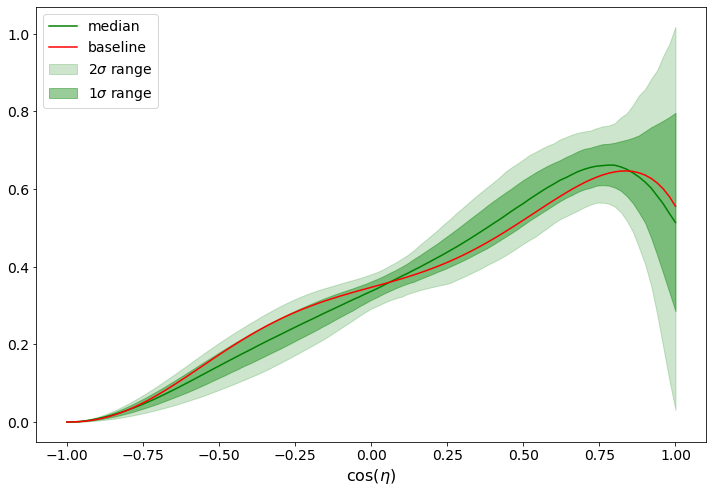

In [14]:
plt.fill_between(xnew, p25, p975, alpha=0.2, color='green', label=r'2$\sigma$ range')
plt.fill_between(xnew, p16, p84, alpha=0.4, color='green', label=r'1$\sigma$ range')
plt.plot(xnew, p50, color='g', label='median')
plt.plot(xnew, models['baseline'], c='r', label='baseline')
plt.gca().set_xlabel(r'$\cos(\eta)$')
plt.legend(loc='upper left')
plt.savefig('envelope.png')

# Fit back to original models
How good does it approximate the original functions? This also gives us the paramaters p0 and p1 to approximate the old models

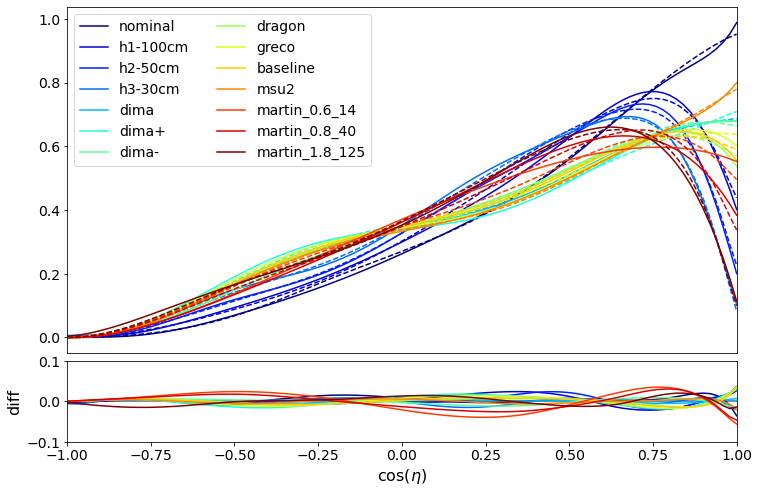

In [15]:
def fun(params, target):
    diff = ang(params, xnew) - target
    return np.sqrt(np.sum(np.square(diff)))

fig = plt.figure()
ax1 = plt.subplot2grid((10,1), (0,0), rowspan=8, fig=fig)
ax2 = plt.subplot2grid((10,1), (8,0),sharex=ax1,rowspan=2, fig=fig)

new_params = {}

for target, name, color in zip(models.values(), models.keys(), colors):
    
    opt = optimize.minimize(fun, x0=np.zeros(out.shape[1]), method='BFGS', args=(target)) 
    new_params[name] = opt['x']

    new = ang(opt['x'], xnew)
    ax1.plot(xnew, new, '--', c=color)
    ax1.plot(xnew, target, label=name, c=color)
    ax2.plot(xnew, new - target, c=color)


ax1.set_xlim([-1,1])
ax2.set_xlim([-1,1])
ax1.get_xaxis().set_visible(False)

ax2.set_ylim([-0.1, 0.1])
ax2.hlines(0,-1,1)
ax2.set_ylabel('diff')
ax2.set_xlabel(r'$\cos(\eta)$')

ax1.legend(loc='upper left', ncol=2)
plt.show()
fig.savefig('approx_new.png')

# morph from one to another model
Let's have some fun by morphing between models in intermediate steps

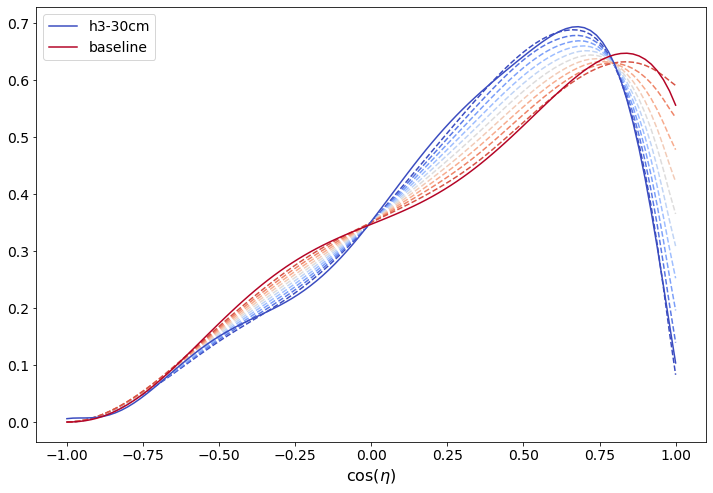

In [16]:
n = 10

m2 = 'baseline'
m1 = 'h3-30cm'

param_space = np.zeros((int(n), n_components))

for i in range(n_components):
    param_space[:,i] = np.linspace(new_params[m1][i], new_params[m2][i], n, endpoint=True)

cmap = cm.coolwarm

for i in range(int(n)):
    plt.plot(xnew, ang(param_space[i], xnew), c=cmap(i/n), ls='--')
    
plt.plot(xnew, models[m1], color=cmap(0.), label=m1)
plt.plot(xnew, models[m2], color=cmap(1.), label=m2)
plt.legend()
plt.gca().set_xlabel(r'$\cos(\eta)$')

plt.savefig('morph.png')

Here is the table of params for the old models

In [17]:
import pandas as pd
df = pd.DataFrame(new_params)
df = df.transpose()
df.columns = ['p0', 'p1']
df

,p0,p1
nominal,0.567771,0.168269
h1-100cm,-0.123027,0.131104
h2-50cm,-0.405128,0.075841
h3-30cm,-0.595997,0.017468
dima,0.232258,-0.042754
dima+,0.265798,-0.070837
dima-,0.198792,-0.014733
dragon,0.072961,-0.043175
greco,0.167150,-0.060809
baseline,0.101569,-0.049344


## make it into a small python module

This cell will generate a .py module

In [18]:
module_src = '''from __future__ import division, print_function
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import make_interp_spline
from numpy.polynomial import polynomial

# these values are obtained from a fit (explained in https://github.com/philippeller/angular_acceptance/blob/master/Angular_acceptance.ipynb)
'''
module_src += 'support_x = np.%s'%repr(support_x)
module_src += '\ncomponents = np.%s'%repr(transformer.components_)
module_src += '\nmean = np.%s'%repr(transformer.mean_)
module_src += '\nn_components = %s'%n_components
module_src += '''

def ang(params, values):
    """
    New angular acceptance function
    
    params : list / array
        the parameters p0, p1, ...
    values : float, list, array
        the eta values to compute the angular acceptance for in (-1, 1)
    """
    # sanity check
    assert np.all(np.logical_and(np.greater_equal(values, -1), np.less_equal(values, 1))), 'values must be in range -1, 1'
    p = np.zeros(n_components)
    p[:len(params)] = params
    # inverse PCA transform
    transformed_params = np.dot(p, components) + mean
    # construct spline
    f = make_interp_spline(support_x, transformed_params, bc_type=([(1, 0.)], [(1, 0.)]))
    # make sure we're positive everywhere
    positive_f = lambda x : np.clip(f(x), 0., None)
    # normalize
    norm = quad(positive_f, -1, 1)
    out = positive_f(values)
    #normalize....why 0.68?
    out *= 0.68 / norm[0]
    return out
    
def angsens_poly(params):
    """
    Return standard IceCube format
    
    params : list/array
        the parameters p0, p1, ... 
    """
    
    x = np.linspace(-1,1,101)
    sampled = ang(params, x)
    coeffs = np.zeros(12)
    coeffs[0] = np.max(sampled)
    coeffs[1:] = polynomial.polyfit(x, sampled, 10)
    return coeffs
    
if __name__=='__main__':
    from sys import argv
    params = [0.]*n_components
    if len(argv) > 0:
        params[:len(argv)-1] = [float(a) for a in argv[1:]]
    print('\\n'.join([str(a) for a in angsens_poly(params)]))
'''

h = hashlib.md5(module_src.encode('utf8'))
module_src = '# version %s\n'%h.hexdigest() + module_src

with open('unified_angular_acceptance.py', 'w') as f:
    f.write(module_src)

## Test model

Let's import the module we just generated an test it. It generates icetray splines, which are polynomila coefficients that need to be converted back to make plots

Text(0.5, 0, '$\\cos(\\eta)$')

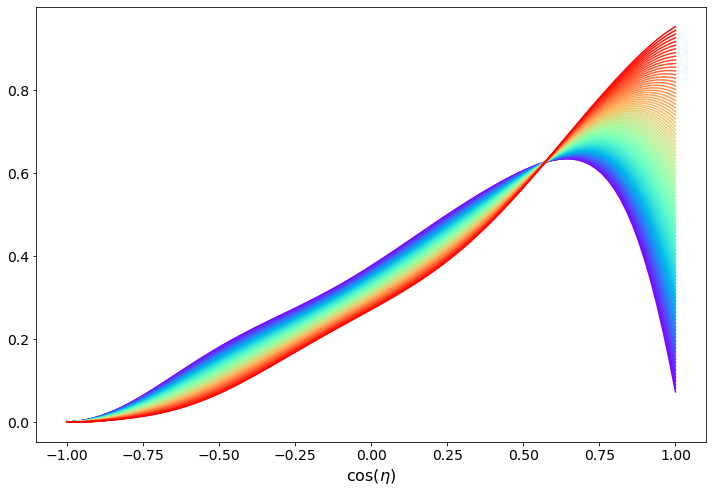

In [19]:
from unified_angular_acceptance import angsens_poly
from numpy.polynomial import polynomial
N = 101
eta = np.linspace(-1,1,101)
for i, p in enumerate(zip(np.linspace(df['p0'].min(), df['p0'].max() ,N), np.linspace(df['p1'].min(),df['p1'].max(),N))):
    coef = angsens_poly(p)
    newf = polynomial.Polynomial(coef[1:])
    plt.plot(eta, newf(eta), c=cm.rainbow(i/N))
plt.gca().set_xlabel(r'$\cos(\eta)$')

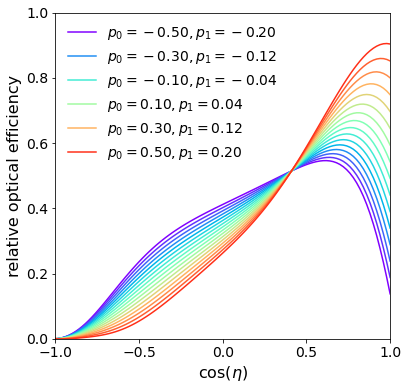

In [20]:
%matplotlib inline
from unified_angular_acceptance import angsens_poly
from numpy.polynomial import polynomial
N = 16
eta = np.linspace(-1,1,101)

fig, ax  = plt.subplots(1,1, figsize=(6,6))

for i, p in enumerate(zip(np.linspace(-0.5, 0.5 ,N), np.linspace(-0.2, 0.2,N))):
    coef = angsens_poly(p)
    newf = polynomial.Polynomial(coef[1:])
    if i % 3 == 0:
        label = r'$p_0=%.2f, p_1=%.2f$'%p
    else:
        label=None
    plt.plot(eta, newf(eta), c=cm.rainbow(i/N), label=label)
plt.gca().set_xlabel(r'$\cos(\eta)$')
plt.gca().set_ylabel(r'relative optical efficiency')
plt.legend(frameon=False)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)
plt.savefig("aa.png", bbox_inches="tight")
plt.savefig("aa.pdf", bbox_inches="tight")

Here we look at p0 and p1 separately in sweeps

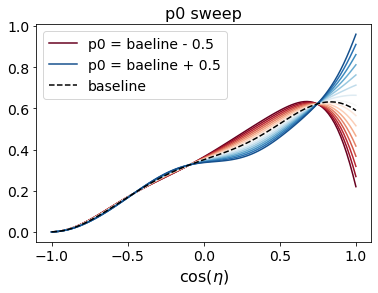

In [21]:
for i, p in enumerate(zip(np.linspace(df.loc['baseline']['p0'] -0.5, df.loc['baseline']['p0'] +0.5,N), np.linspace(df.loc['baseline']['p1'],df.loc['baseline']['p1'],N))):
    coef = angsens_poly(p)
    newf = polynomial.Polynomial(coef[1:])
    if i == 0:
        label = 'p0 = baeline - 0.5'
    elif i == N - 1:
        label = 'p0 = baeline + 0.5'
    else:
        label = None
    
    plt.plot(eta, newf(eta), c=cm.RdBu(i/N), label=label)

coef = angsens_poly(df.loc['baseline'].values)
newf = polynomial.Polynomial(coef[1:])
plt.plot(eta, newf(eta), c='k', ls='--', label='baseline')    

plt.legend()
    
plt.title('p0 sweep')
plt.gca().set_xlabel(r'$\cos(\eta)$')
plt.savefig('p0_sweep.png')

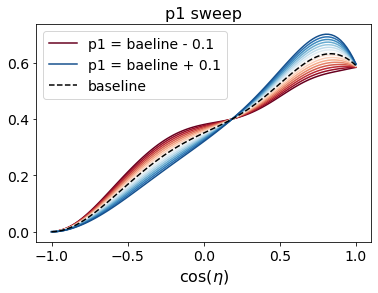

In [22]:
for i, p in enumerate(zip(np.linspace(df.loc['baseline']['p0'], df.loc['baseline']['p0'],N), np.linspace(df.loc['baseline']['p1']-0.1,df.loc['baseline']['p1']+0.1,N))):
    coef = angsens_poly(p)
    newf = polynomial.Polynomial(coef[1:])
    if i == 0:
        label = 'p1 = baeline - 0.1'
    elif i == N - 1:
        label = 'p1 = baeline + 0.1'
    else:
        label = None
    
    plt.plot(eta, newf(eta), c=cm.RdBu(i/N), label=label)

coef = angsens_poly(df.loc['baseline'].values)
newf = polynomial.Polynomial(coef[1:])
plt.plot(eta, newf(eta), c='k', ls='--', label='baseline')    

plt.legend()
    
plt.title('p1 sweep')
plt.gca().set_xlabel(r'$\cos(\eta)$')
plt.savefig('p1_sweep.png')

## Dima flasher fits

Dima fited the model to sigle LED flasher data, details here: https://drive.google.com/file/d/1Y3flzWbYobR7DFYRnBu0WM4oXc1Qrxnn/view?usp=sharing

In [23]:
# from dima's fit:
best_p = {}
best_p['all'] = [-0.427318  ,  -0.0675806]
best_p['tilted'] = [-0.501349  ,  -0.0876635]
best_p['horizontal'] = [-0.378935  ,  -0.0385643]


#best_p['all_div'] = [0.846887  ,  -0.481283]
#best_p['tilted_div'] = [0.944486  ,  -0.579109]
#best_p['horizontal_div'] = [0.881531  ,  -0.438632]



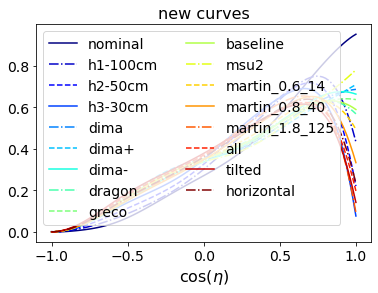

In [24]:
all_curves = {**new_params,**best_p, }

#models.pop('nominal')
#models.pop('msu2')

N = len(models) + len(best_p)

colors = cm.jet(np.linspace(0,1,N))
ls = ['-','-.','--']

#for i, (m, c) in enumerate(models.items()):
#    plt.plot(eta, c, label=m, c=colors[i], ls=ls[i%len(ls)])

    
for i, (fit, p) in enumerate(new_params.items()):
    coef = angsens_poly(p)
    newf = polynomial.Polynomial(coef[1:])
    plt.plot(eta, newf(eta), label=fit, c=colors[i], ls=ls[i%len(ls)])
    
for j, (fit, p) in enumerate(best_p.items()):
    coef = angsens_poly(p)
    newf = polynomial.Polynomial(coef[1:])
    plt.plot(eta, newf(eta), label=fit, c=colors[i+j+1], ls=ls[(i+j+1)%len(ls)])
    #plt.plot(eta, ang(p, eta), label=fit, c=colors[i+j+1], ls=ls[(i+j+1)%len(ls)])
plt.legend(ncol=2)
plt.title('new curves')
plt.gca().set_xlabel(r'$\cos(\eta)$')
plt.savefig('busy_plot.png')

In [25]:
all_params = {**new_params ,**best_p}

In [26]:
df = pd.DataFrame(all_params)
df = df.transpose()
df.columns = ['p0', 'p1']
df

,p0,p1
nominal,0.567771,0.168269
h1-100cm,-0.123027,0.131104
h2-50cm,-0.405128,0.075841
h3-30cm,-0.595997,0.017468
dima,0.232258,-0.042754
dima+,0.265798,-0.070837
dima-,0.198792,-0.014733
dragon,0.072961,-0.043175
greco,0.167150,-0.060809
baseline,0.101569,-0.049344


## Explore space of all models

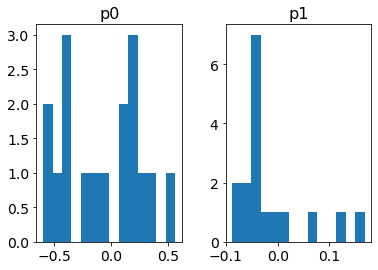

In [27]:
df.hist(grid=False, bins=14);

In [28]:
import seaborn as sns

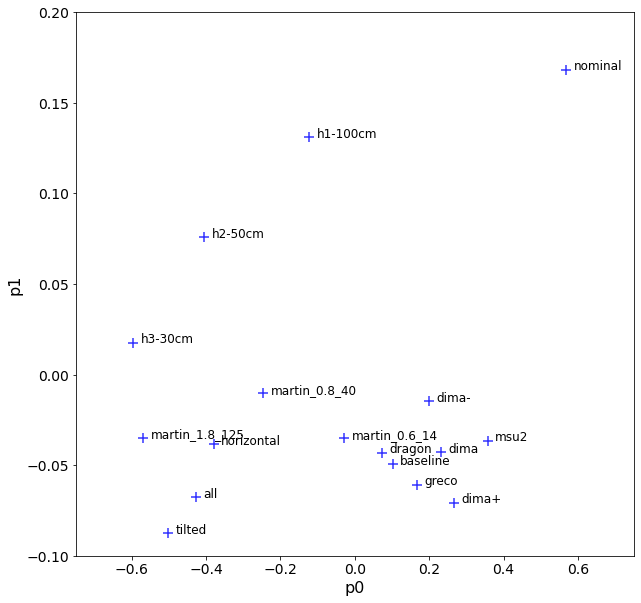

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

p = sns.regplot(data=df, x="p0", y="p1", fit_reg=False, marker="+", scatter_kws={'s':100}, color="blue", ax=ax)
for line in range(0,df.shape[0]):
     p.text(df.p0[line]+0.02, df.p1[line], df.index[line], horizontalalignment='left', size='medium', color='black', fontsize=12, )
plt.gca().set_xlim((-0.75, 0.75))
plt.gca().set_ylim((-0.1, 0.2))
plt.savefig('landscape.png', dpi=300)

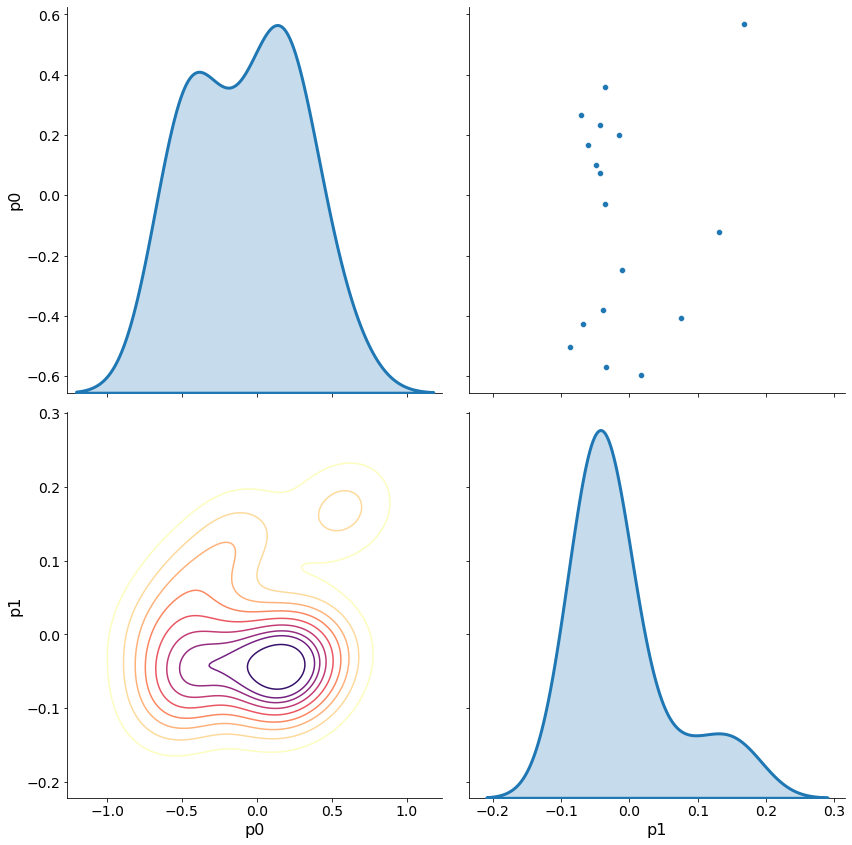

In [30]:
g = sns.PairGrid(df, diag_sharey=False, height=6)
g.map_lower(sns.kdeplot, cmap='magma_r')
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3, shade=True, )

plt.savefig('facets.png')

# Generate systematics sets
spanning the interesting space in a low discrepancy sequence

In [31]:
''' from http://extremelearning.com.au/unreasonable-effectiveness-of-quasirandom-sequences/'''
# Using the above nested radical formula for g=phi_d 
# or you could just hard-code it. 
# phi(1) = 1.61803398874989484820458683436563 
# phi(2) = 1.32471795724474602596090885447809 
def phi(d): 
    x=2.0000 
    for i in range(10): 
        x = pow(1+x,1/(d+1)) 
    return x

# Number of dimensions. 
d=2 

# number of required points 
n=100

g = phi(d) 
alpha = np.zeros(d) 
for j in range(d): 
    alpha[j] = pow(1/g,j+1) %1 
sample = np.zeros((n, d)) 

# This number can be any real number. 
# Common default setting is typically seed=0
# But seed = 0.5 is generally better. 

seed = 0.5

for i in range(n): 
    sample[i] = (seed + alpha*(i+1)) %1
    
sample = sample.T

In [32]:
sample = pd.DataFrame([sample[0], sample[1]]).T
sample.columns = ['p0', 'p1']

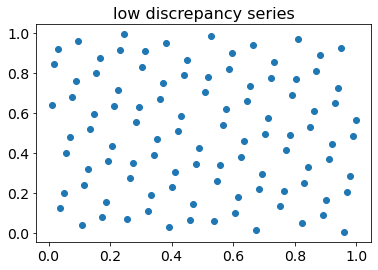

In [33]:
plt.scatter(sample['p0'], sample['p1'])
plt.title('low discrepancy series')
plt.savefig('low_discrepancy_series.png')

In [34]:
sample = 1 - sample

In [35]:
# I chose these values by hand to cover a reasonable region

sample['p0'] = stats.norm.isf(sample['p0'], loc=0.1, scale=0.25)
sample['p1'] = stats.norm.isf(sample['p1'], loc=-0.035, scale=0.05)

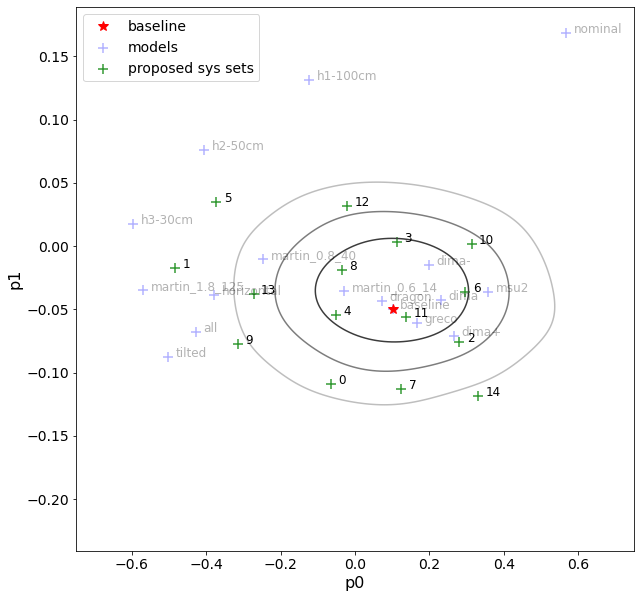

In [36]:
fig, ax = plt.subplots(figsize=(10,10))

data = sample[:15]


p = sns.regplot(data=df, x="p0", y="p1", fit_reg=False, marker="+", scatter_kws={'s':100, 'alpha':0.3}, color="blue", ax=ax, label='models')
for line in range(0,df.shape[0]):
     p.text(df.p0[line]+0.02, df.p1[line], df.index[line], horizontalalignment='left', size='medium', color='black', fontsize=12, alpha=0.3)
plt.gca().set_xlim((-0.75, 0.75))
#plt.gca().set_ylim((-0.1, 0.2))


p = sns.regplot(data=data, x="p0", y="p1", fit_reg=False, marker="+", scatter_kws={'s':100}, color="g", ax=ax, label='proposed sys sets')
for line in range(0,data.shape[0]):
     p.text(data.p0[line]+0.02, data.p1[line], data.index[line], horizontalalignment='left', size='medium', color='black', fontsize=12, )
        
plt.plot(df.loc['baseline'][0], df.loc['baseline'][1], '*', c='r', ms=10, label='baseline')
plt.legend()

sns.kdeplot(sample['p0'], y=sample['p1'], ax=ax, cmap='gray_r', n_levels=5)

plt.savefig('models_scatter.png')

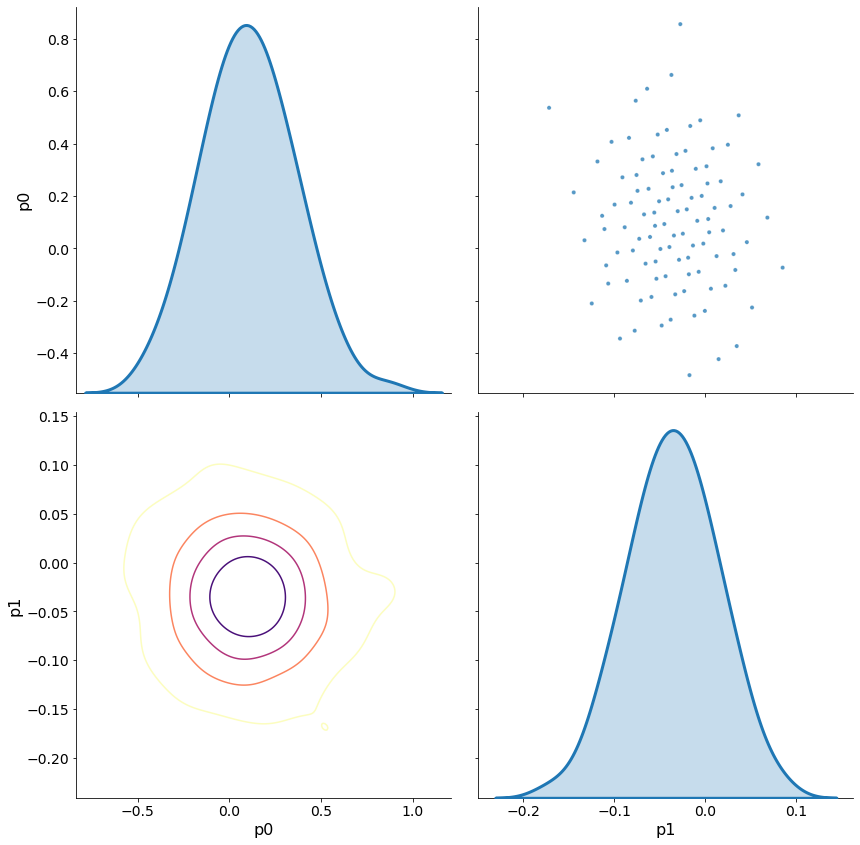

In [37]:
g = sns.PairGrid(sample, diag_sharey=False, height=6)
g.map_lower(sns.kdeplot, cmap='magma_r', n_levels=5)
g.map_upper(sns.scatterplot, size=1, alpha=0.75)
g.map_diag(sns.kdeplot, lw=3, shade=True, )
plt.savefig('sys_models_facets.png')

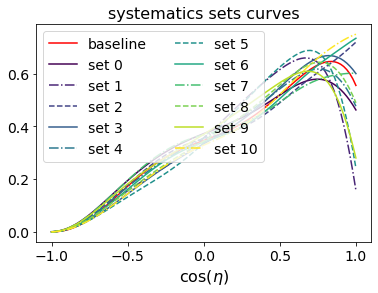

In [38]:
N = 11

colors = cm.viridis(np.linspace(0,1,N))
ls = ['-','-.','--']

#for i, (m, c) in enumerate(models.items()):
#    plt.plot(eta, c, label=m, c=colors[i], ls=ls[i%len(ls)])

plt.plot(eta, models['baseline'], label='baseline', c='r', ls='-')
    
for i in range(N):
    coef = angsens_poly(sample.loc[i].values)
    newf = polynomial.Polynomial(coef[1:])
    plt.plot(eta, newf(eta), label='set %i'%i, c=colors[i], ls=ls[i%len(ls)])

plt.legend(ncol=2)
plt.title('systematics sets curves')
plt.gca().set_xlabel(r'$\cos(\eta)$')
plt.savefig('sys_curves.png', dpi=300)

In [39]:
sample

,p0,p1
0,-0.064805,-0.108849
1,-0.483907,-0.017120
2,0.280321,-0.075404
3,0.112231,0.003502
4,-0.049899,-0.054374
...,...,...
95,0.563932,-0.076254
96,0.248042,0.002688
97,0.086212,-0.055032
98,-0.082343,0.033349


In [40]:
# write as files
for i in range(50):
    with open('sys_models/as.set%i_p0=%.2g_p1=%.2g'%(i, sample.loc[i].values[0], sample.loc[i].values[1]), 'w') as f:
        f.write('\n'.join([str(c) for c in angsens_poly(sample.loc[i].values)]))